<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# local python libraries
import re

# --Addition
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# External Pythons
%run -i ./pythons/cross_validation.py
%run -i ./pythons/features_engineering.py
%run -i ./pythons/linear_regression.py
%run -i ./pythons/plotting.py
%run -i ./pythons/regularization.py
%run -i ./pythons/m_df.py
%run -i ./pythons/m_perform.py
%run -i ./pythons/mine.py

# Setup for Vizualization
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### 1&2. EDA, feature engineering

In [3]:
## Drop row with value "C (all)"
house = house[house['MSZoning'] != 'C (all)']
print(house['MSZoning'].unique())

['RL' 'RM' 'FV' 'RH']


In [4]:
df_num = feature_dataframe(house)

In [5]:
df_name = get_categorical(house)
df_name.shape

(1450, 43)

### 3. Identify fixed features that can predict price

#### 3.1 Non-Renovated

In [6]:
# Non renovated features:
# - The neighborhood
# - Square feet
# - Bedrooms, bathrooms
# - Basement and garage space
list_non_renovated = ['Neighborhood','LotArea','BedroomAbvGr','Bathrooms','TotalBsmtSF','GarageArea']

#### 3.2 Renovate-able

In [7]:
# ARE renovate-able:
# - Roof and exterior features
# - "Quality" metrics, such as kitchen quality
# - "Condition" metrics, such as condition of garage
# - Heating and electrical components
# ----------------------------------------------------
list_renovate_able = get_renovate_able_list(get_categorical(house))
list_renovate_able

['RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'BsmtQual',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'ExterCond',
 'BsmtCond',
 'GarageCond',
 'HeatingQC',
 'PoolQC']

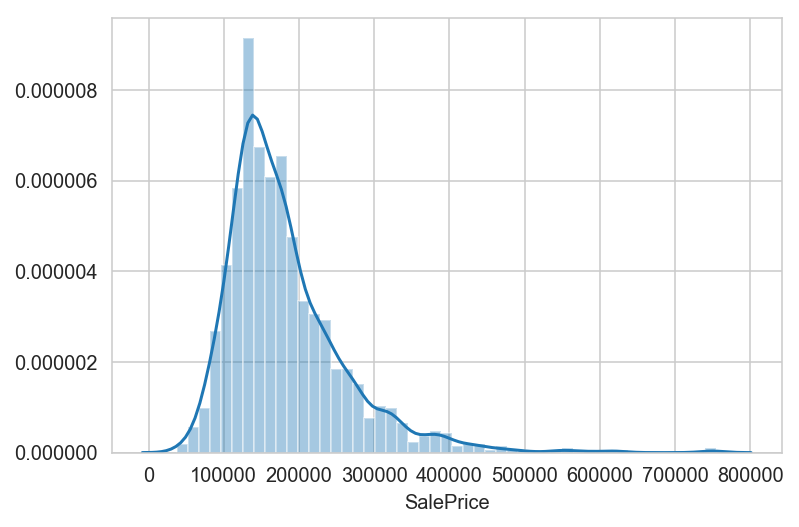

In [8]:
sns.distplot(house['SalePrice']);

### 4.Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [9]:
# Drop "Negative Correlation" and  "no relationship" with YrSold
list_drop = ['MSSubClass']
house.drop(labels=list_drop, axis=1, inplace=True)

#### 4.1 Identify pre-2010 Dataframe

In [10]:
df_pre_2010 = build_pre_2010_df(house)
df_pre_2010.shape

(1278, 80)

In [11]:
df_pre_2010.head()

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 4.2 Identify post-2010 Dataframe

In [12]:
df_post_2010 = build_post_2010_df(house)
df_post_2010.shape

(172, 80)

In [13]:
df_post_2010.head()

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
16,17,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
24,25,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000
26,27,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,134800
27,28,RL,98.0,11478,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,306000
33,34,RL,70.0,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500


### 5. Characterize your model. How well does it perform? What are the best estimates of price?

#### 5.1 Characterize your model [pre-2010]

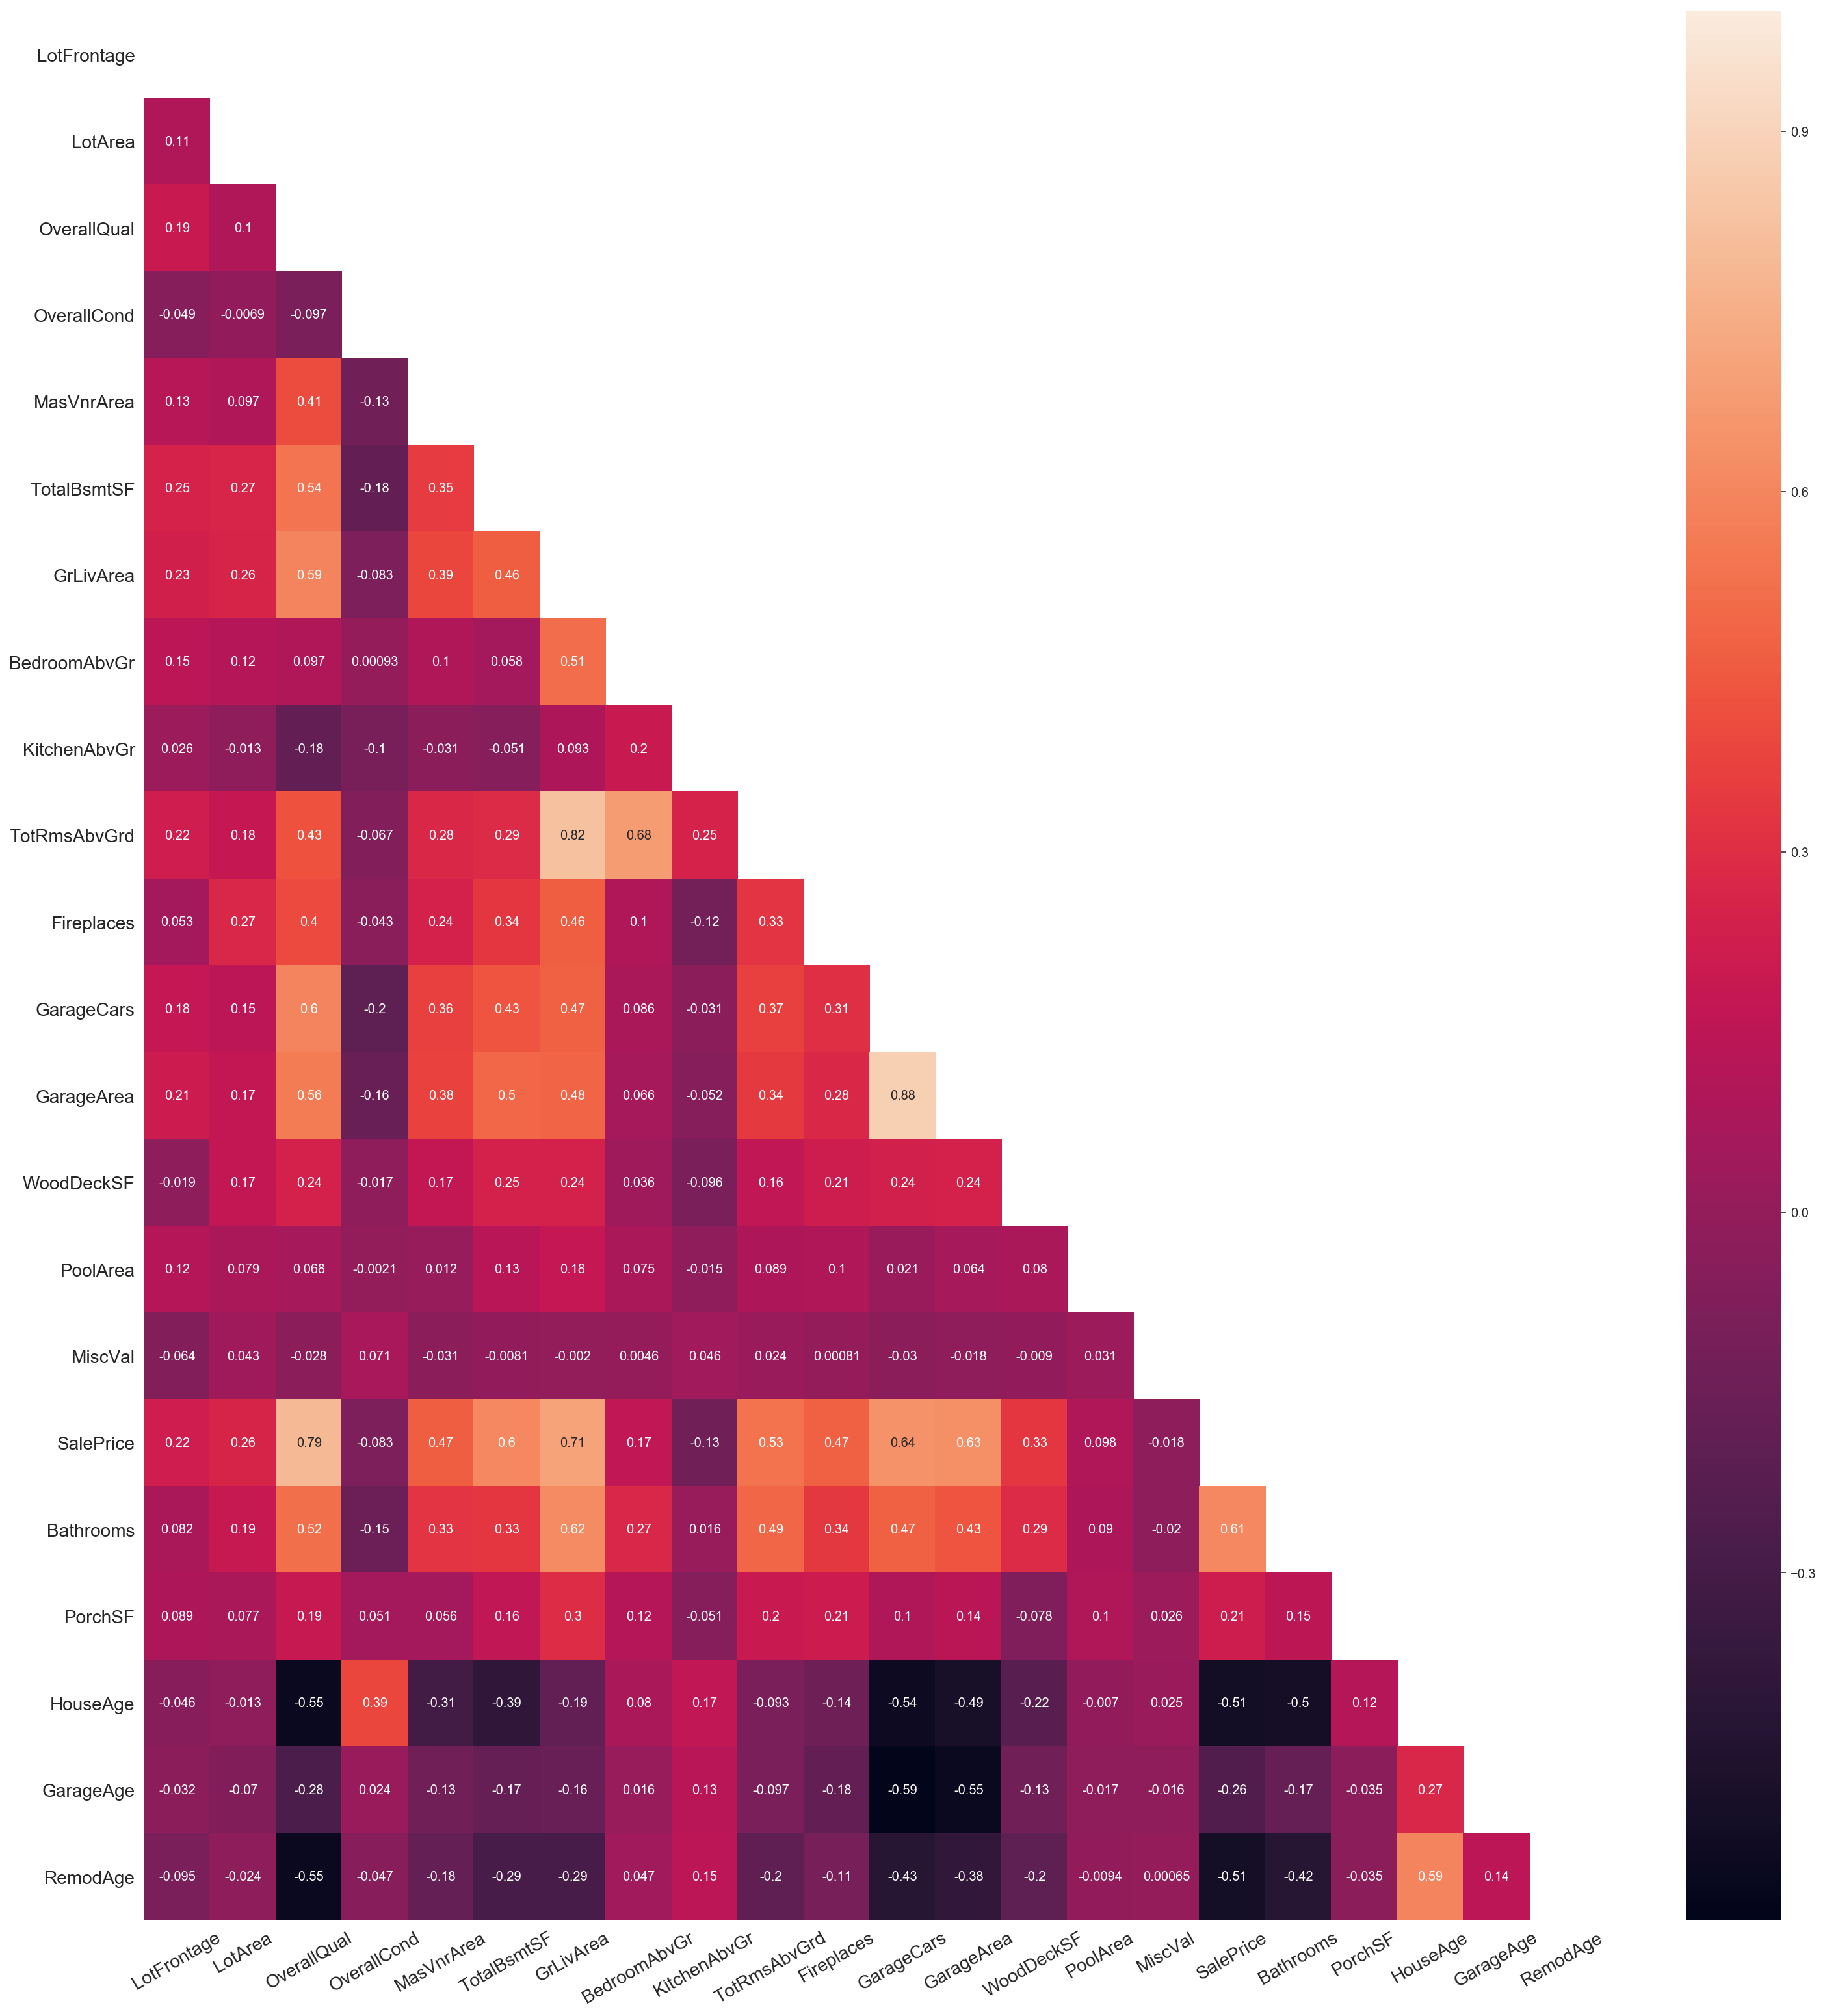

In [14]:
# Init pre-2010 numberics
df_pre_num, df_pre_name = feature_dataframe_w_age(df_pre_2010)

In [15]:
# My Dataframe [pre-2010]
df_pre_renovate, df_pre_convertable = m_build_df(df_pre_name)
df_pre_renovate.head()

C:\Users\Shaynie\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,BsmtQual,KitchenQual,FireplaceQu,GarageQual,ExterCond,BsmtCond,GarageCond,HeatingQC,PoolQC
0,Gable,CompShg,VinylSd,VinylSd,4,4,4,0,3,3,3,3,5,0
1,Gable,CompShg,MetalSd,MetalSd,3,4,3,3,3,3,3,3,5,0
2,Gable,CompShg,VinylSd,VinylSd,4,4,4,3,3,3,3,3,5,0
3,Gable,CompShg,Wd Sdng,Wd Shng,3,3,4,4,3,3,4,3,4,0
4,Gable,CompShg,VinylSd,VinylSd,4,4,4,3,3,3,3,3,5,0


In [16]:
df_pre_convertable.head()

,CentralAir,PavedDrive,BsmtExposure,GarageFinish,LotShape,Street,Alley,LandContour,Utilities,LandSlope,Fence
0,1,3,1,2,4,1,0,4,4,3,0
1,1,3,4,2,4,1,0,4,4,3,0
2,1,3,2,2,-1,1,0,4,4,3,0
3,1,3,1,1,-1,1,0,4,4,3,0
4,1,3,3,2,-1,1,0,4,4,3,0


In [17]:
df_pre_name.shape

(1278, 18)

#### 5.2 Characterize your model [post-2010]

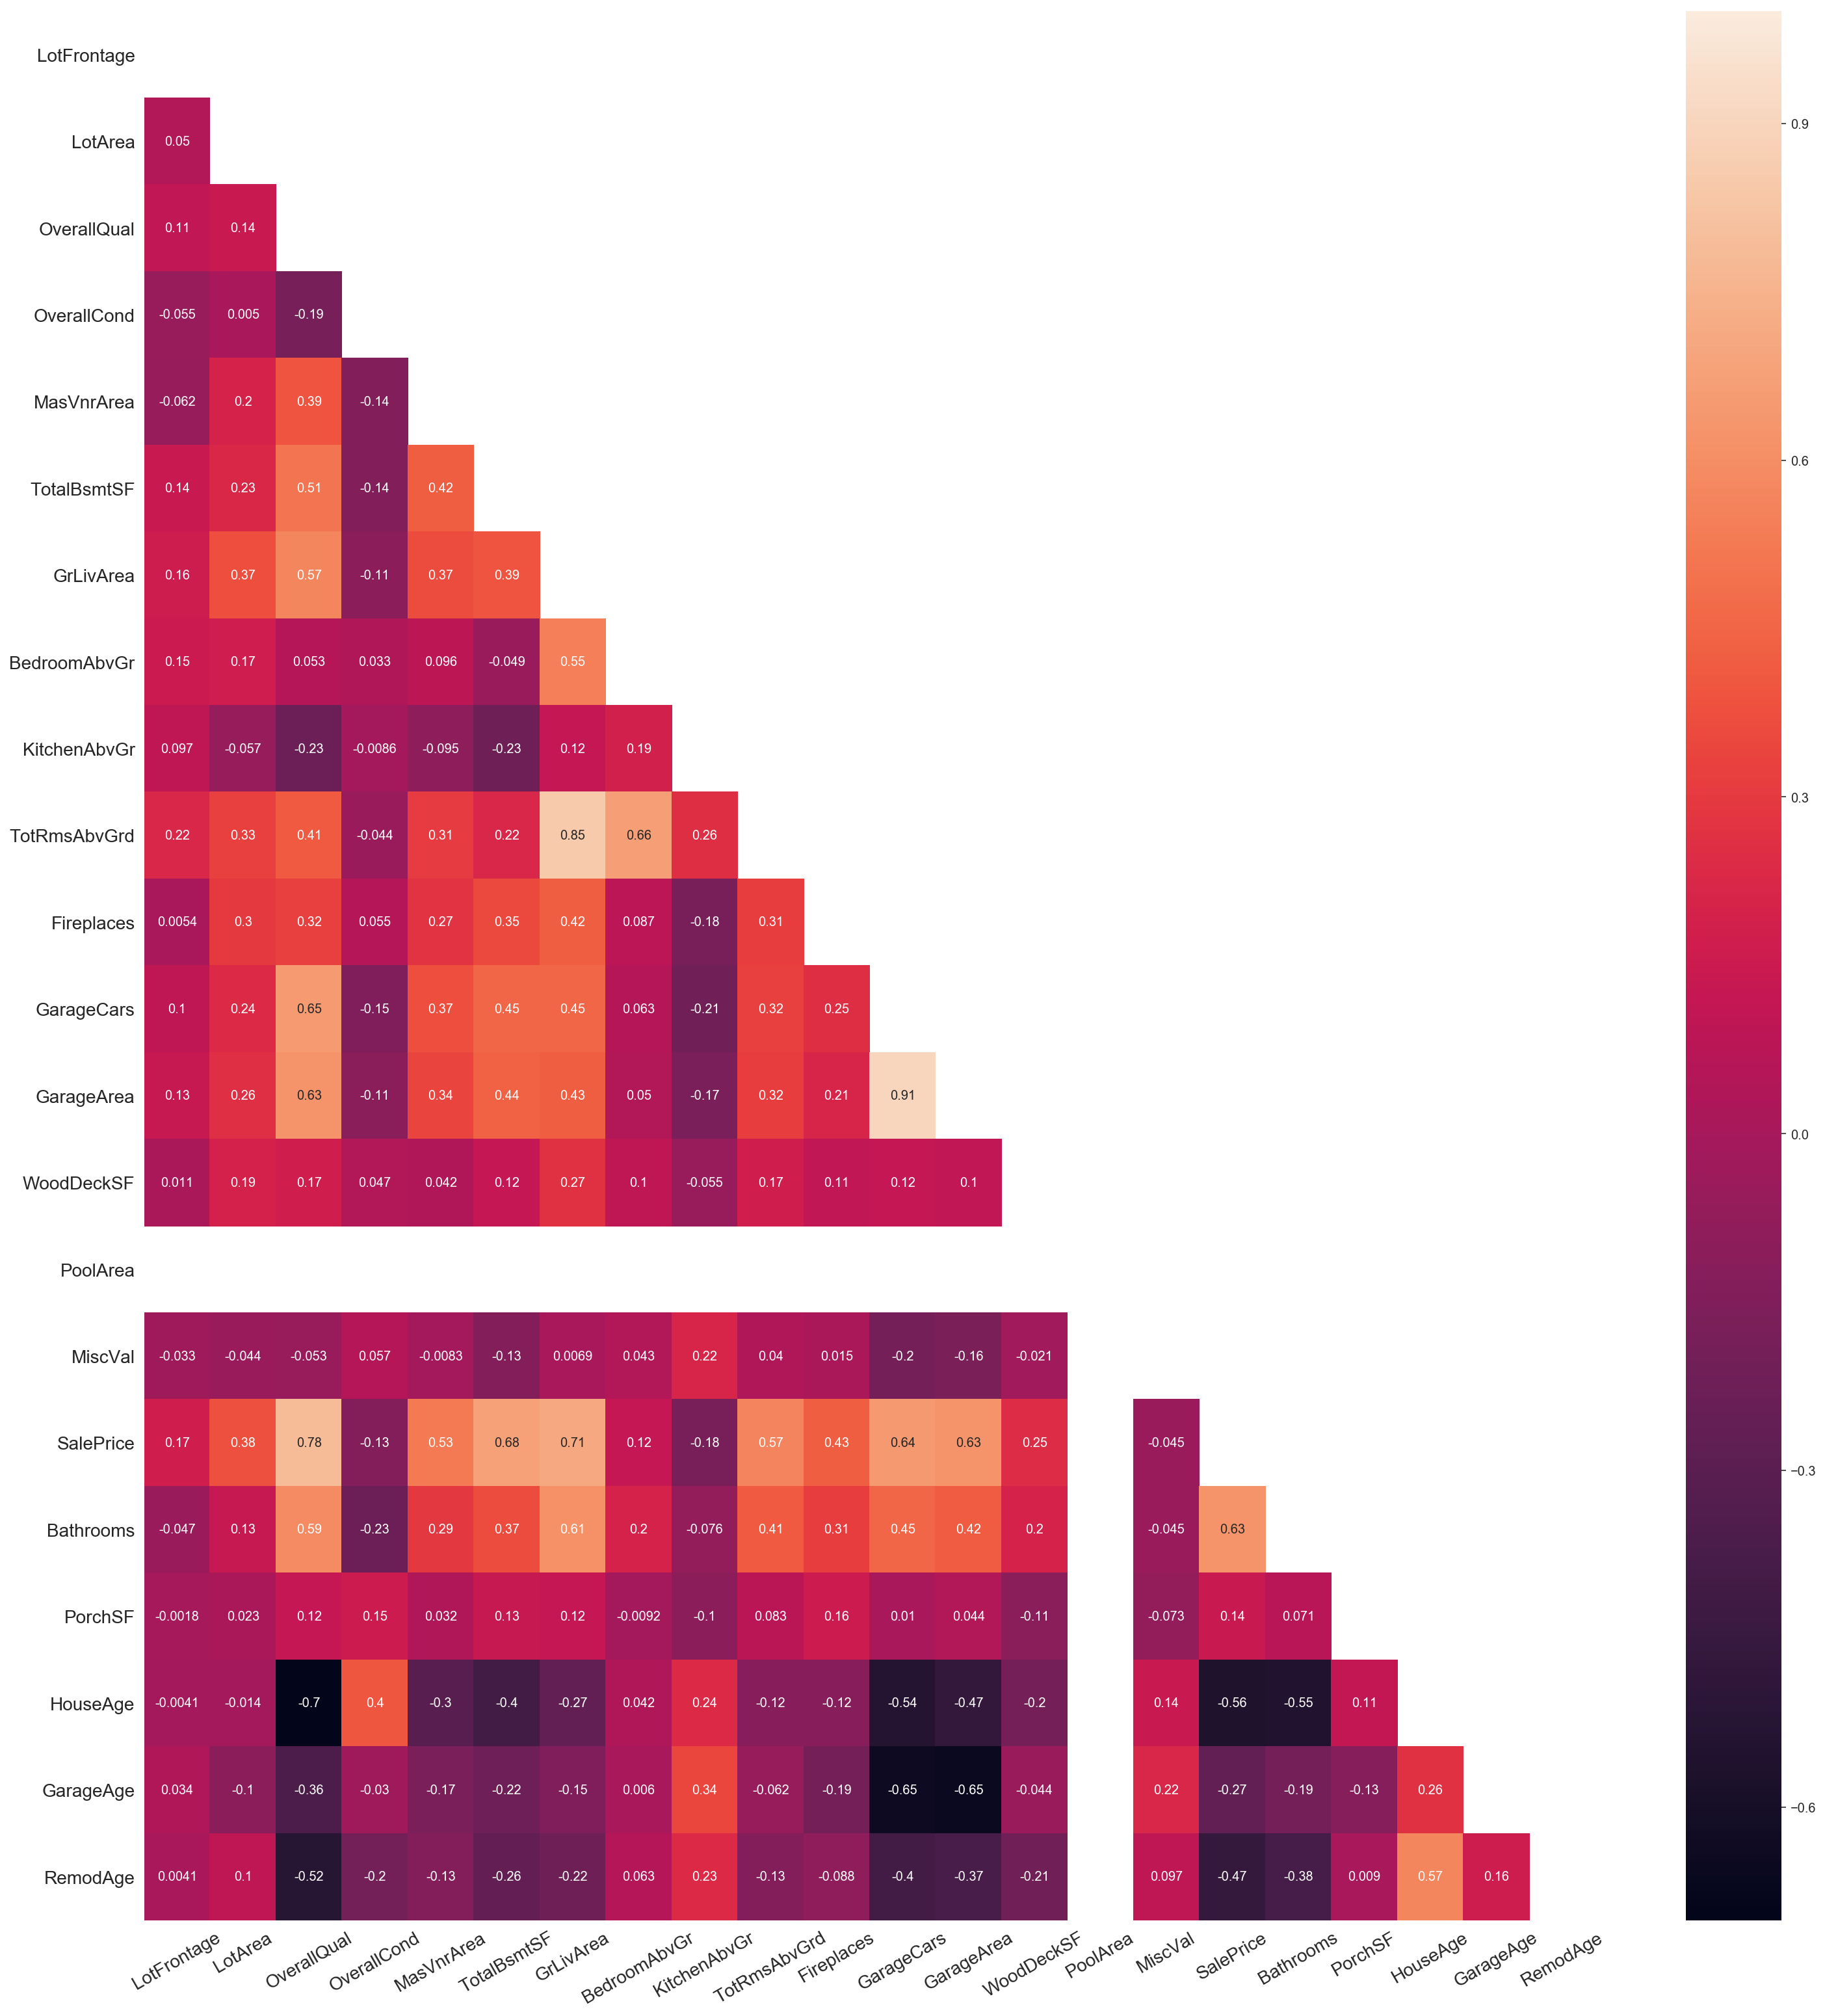

In [18]:
df_post_num, df_post_name = feature_dataframe_w_age(df_post_2010)

In [19]:
# My Dataframe [pre-2010]
df_post_renovate, df_post_convertable = m_build_df(df_post_name)
df_post_renovate.head()

C:\Users\Shaynie\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,BsmtQual,KitchenQual,FireplaceQu,GarageQual,ExterCond,BsmtCond,GarageCond,HeatingQC,PoolQC
16,Gable,CompShg,Wd Sdng,Wd Sdng,3,3,3,3,3,3,3,3,5,0
24,Gable,CompShg,Plywood,Plywood,3,3,4,3,3,4,3,3,5,0
26,Gable,CompShg,Wd Sdng,Wd Sdng,3,3,4,0,3,3,3,3,3,0
27,Gable,CompShg,VinylSd,VinylSd,4,5,4,4,3,3,3,3,5,0
33,Hip,CompShg,BrkFace,BrkFace,3,3,4,4,3,3,3,3,4,0


In [20]:
df_post_convertable.head()

,CentralAir,PavedDrive,BsmtExposure,GarageFinish,LotShape,Street,Alley,LandContour,Utilities,LandSlope,Fence
16,1,3,1,3,-1,1,0,4,4,3,0
24,1,3,2,1,-1,1,0,4,4,3,3
26,1,3,2,1,4,1,0,4,4,3,0
27,1,3,1,2,4,1,0,4,4,3,0
33,1,3,1,2,-1,1,0,4,4,3,0


#### 5.3 How well does it perform?

In [21]:
# ROUND 1
## Pre-perform
# list_corr = df_pre_num.corr()['SalePrice'].sort_values()
# list_corr = dict(list_corr)
# list_drop_name = []
# for key, value in list_corr.items():
#     if value > -0.15 and value < .15:
#         list_drop_name.append(key)
        
# list_drop_name

# df_pre_num.drop(labels=list_drop_name, axis=1, inplace=True)
# df_post_num.drop(labels=list_drop_name, axis=1, inplace=True)

In [22]:
df_pre_num.shape

(1278, 22)

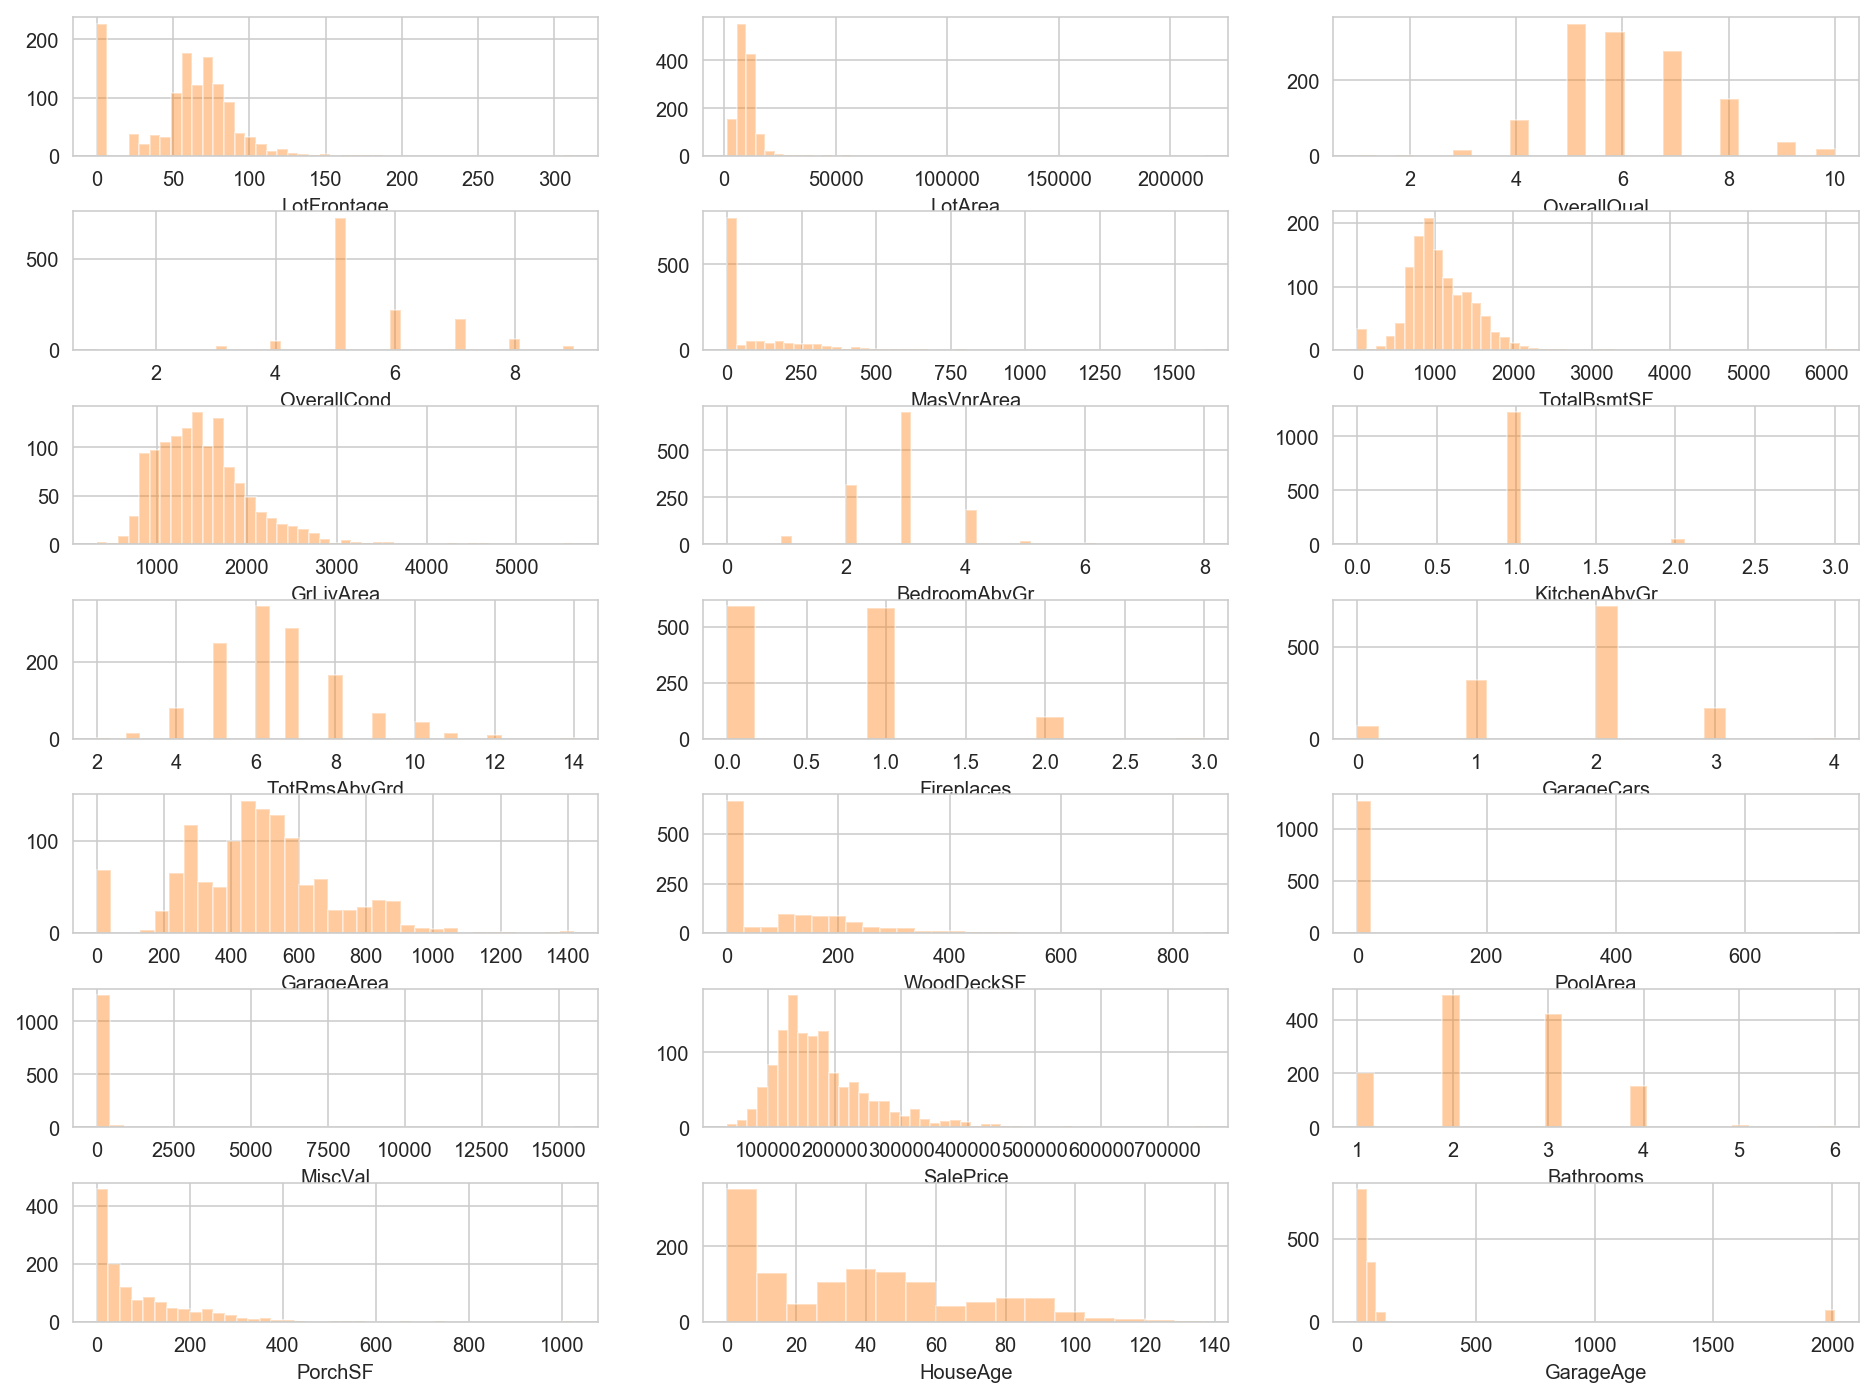

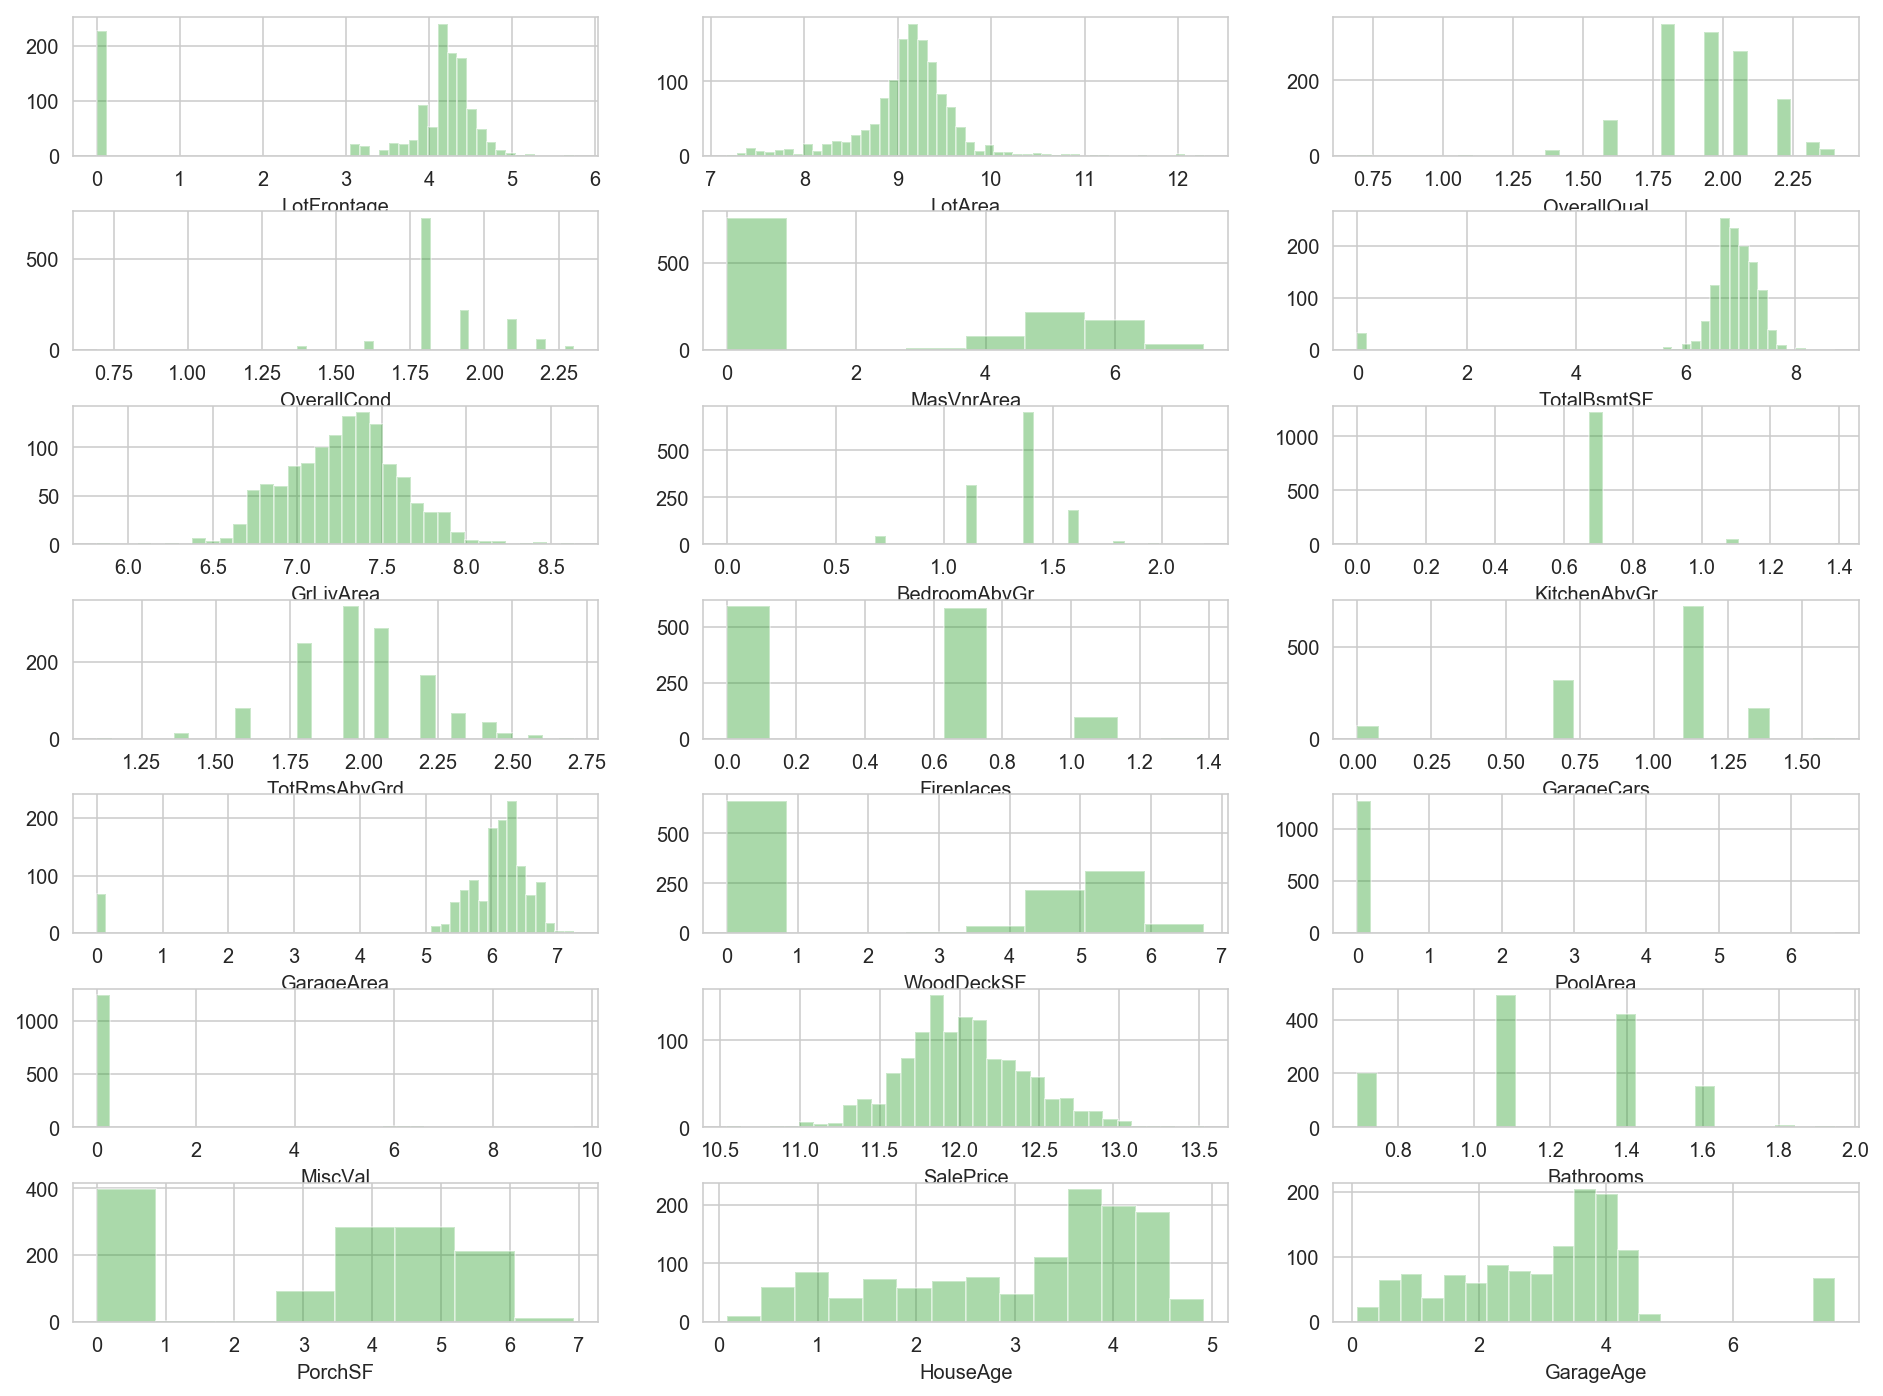

Train-split-test (Test) score:  0.8315442089554366
Train-split-test (Train) score:  0.8681580993747484
-----------------------------------------------------


K-Fold Cross-validated scores: 

Score Mean:  0.8530778941317546
Cross-Predicted R2:  0.8551860362880689
-----------------------------------------------------




C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Ridge Alpha:  40.5546073584083
[0.89291624 0.89443163 0.89118268 0.83719938 0.85014641 0.86440538
 0.85455012 0.86174132 0.73500778 0.84923205]
RidgeCV Mean:  0.8530813002769706
-----------------------------------------------------




........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso Alpha:  0.00124742362190662
[0.9008138  0.90010708 0.88001677 0.88065165 0.91744046 0.86762553
 0.91122255 0.89248164 0.87284115 0.8541642  0.76095757 0.85954424
 0.84362372 0.84225074 0.87420234 0.89894375 0.88764979 0.80438424
 0.89750789 0.78174632 0.9047666  0.86256707 0.84632002 0.86655513
 0.78656752 0.84953271 0.19221957 0.86940535 0.87618635 0.80622465]
LassoCV Mean:  0.8396173462331965
-----------------------------------------------------




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNet Alpha:  0.001261456169344716
1.0
[0.89363114 0.89625317 0.89097174 0.83594174 0.85198672 0.86412496
 0.85891585 0.86158466 0.73681426 0.85223809]
ElasticCV Mean:  0.8542462325979432
-----------------------------------------------------


{'Base woStd': 0.8627703754510582, 'Base wStd': -5.04867595080468, 'Pred': 6.6272508522724936, 'y': 179167.0}


{'Base woStd': 0.8627703754510582,
 'Base wStd': 0.8627703754510582,
 'TTS-Train': 0.8681580993747484,
 'TTS-Test': 0.8315442089554366,
 'KF-CV score': array([0.8947681 , 0.89496233, 0.89167341, 0.83676674, 0.85369419,
        0.85865785, 0.85589453, 0.86108847, 0.73479919, 0.84847413]),
 'KF-CV Mean score': 0.8530778941317546,
 'R2 score': 0.8551860362880689}

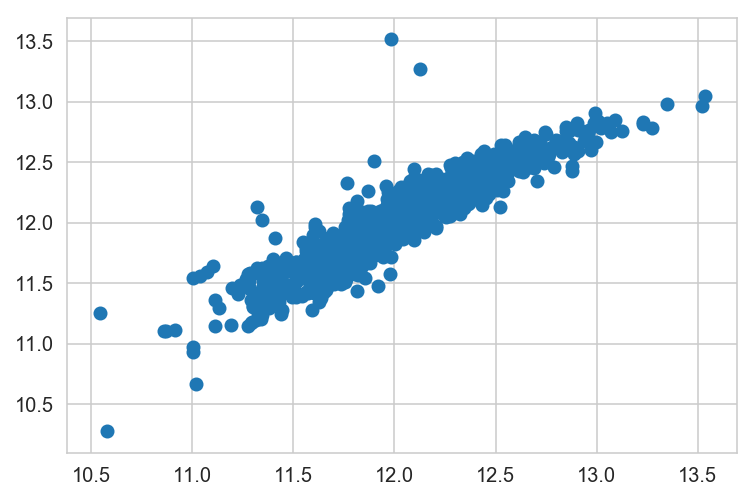

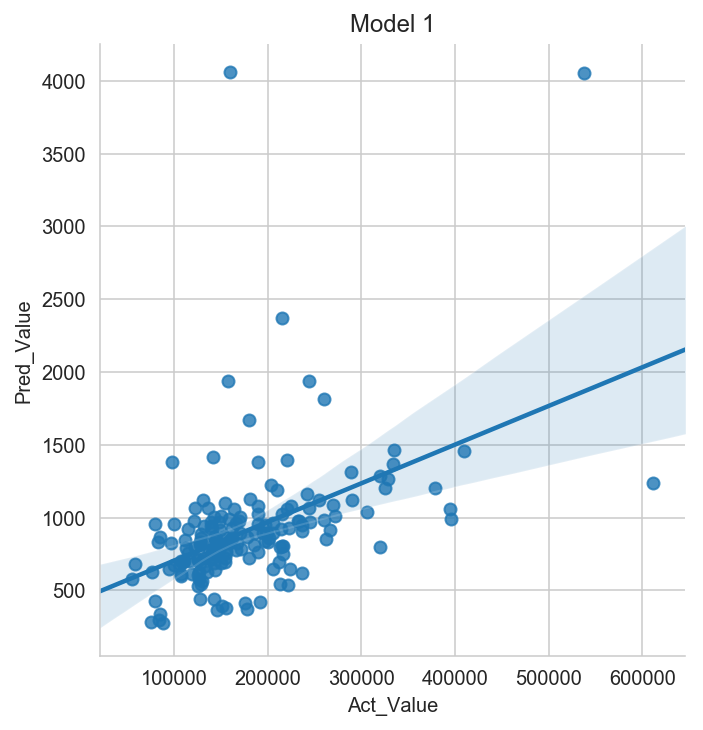

In [23]:
## Perform Non-renovated features
perform1 = let_perform(df_pre_num, df_post_num)
perform1

In [24]:
print(perform1)

{'Base woStd': 0.8627703754510582, 'Base wStd': 0.8627703754510582, 'TTS-Train': 0.8681580993747484, 'TTS-Test': 0.8315442089554366, 'KF-CV score': array([0.8947681 , 0.89496233, 0.89167341, 0.83676674, 0.85369419,
       0.85865785, 0.85589453, 0.86108847, 0.73479919, 0.84847413]), 'KF-CV Mean score': 0.8530778941317546, 'R2 score': 0.8551860362880689}


In [25]:
# plotting_linear_w_features(X,'SalePrice',df_pre_backup)
df_pre_convertable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 0 to 1459
Data columns (total 11 columns):
CentralAir      1278 non-null int64
PavedDrive      1278 non-null int64
BsmtExposure    1278 non-null int64
GarageFinish    1278 non-null int64
LotShape        1278 non-null int64
Street          1278 non-null int64
Alley           1278 non-null int64
LandContour     1278 non-null int64
Utilities       1278 non-null int64
LandSlope       1278 non-null int64
Fence           1278 non-null int64
dtypes: int64(11)
memory usage: 119.8 KB


#### 5.4 What are the best estimates of price?

##### Current Model:
- According to the result, my score is: <b>86%</b> base on my fixed 24 features (non-renovated)
- My estimate is relied on numberics data which is provided within dataset.
- There are no dummies columns converted.

##### Next Model:
- Would include some convertable and renovated columns

In [26]:
df_pre_num.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'PoolArea', 'MiscVal', 'SalePrice', 'Bathrooms', 'PorchSF', 'HouseAge',
       'GarageAge', 'RemodAge'],
      dtype='object')

In [27]:
df_post_num.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'PoolArea', 'MiscVal', 'Bathrooms', 'PorchSF', 'HouseAge', 'GarageAge',
       'RemodAge'],
      dtype='object')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [28]:
# Round 2
## Pre-Perform
# df_pre_num = pd.concat([df_pre_num, df_pre_convertable, get_numberics(df_pre_renovate)], axis=1, join='inner')
# list_corr = df_pre_num.corr()['SalePrice'].sort_values()
# list_corr = dict(list_corr)
# list_corr
# list_drop_name = []
# for key, value in list_corr.items():
#     if value > -0.25 and value < .25:
#         list_drop_name.append(key)
        
# list_drop_name
# df_post_num = pd.concat([df_post_num, df_post_convertable, get_numberics(df_post_renovate)], axis=1, join='inner')
# df_pre_num.drop(labels=list_drop_name, axis=1, inplace=True)
# df_post_num.drop(labels=list_drop_name, axis=1, inplace=True)
df_pre_renovate.head()


,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,BsmtQual,KitchenQual,FireplaceQu,GarageQual,ExterCond,BsmtCond,GarageCond,HeatingQC,PoolQC
0,Gable,CompShg,VinylSd,VinylSd,4,4,4,0,3,3,3,3,5,0
1,Gable,CompShg,MetalSd,MetalSd,3,4,3,3,3,3,3,3,5,0
2,Gable,CompShg,VinylSd,VinylSd,4,4,4,3,3,3,3,3,5,0
3,Gable,CompShg,Wd Sdng,Wd Shng,3,3,4,4,3,3,4,3,4,0
4,Gable,CompShg,VinylSd,VinylSd,4,4,4,3,3,3,3,3,5,0


In [29]:
df_post_renovate.head()

,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,BsmtQual,KitchenQual,FireplaceQu,GarageQual,ExterCond,BsmtCond,GarageCond,HeatingQC,PoolQC
16,Gable,CompShg,Wd Sdng,Wd Sdng,3,3,3,3,3,3,3,3,5,0
24,Gable,CompShg,Plywood,Plywood,3,3,4,3,3,4,3,3,5,0
26,Gable,CompShg,Wd Sdng,Wd Sdng,3,3,4,0,3,3,3,3,3,0
27,Gable,CompShg,VinylSd,VinylSd,4,5,4,4,3,3,3,3,5,0
33,Hip,CompShg,BrkFace,BrkFace,3,3,4,4,3,3,3,3,4,0


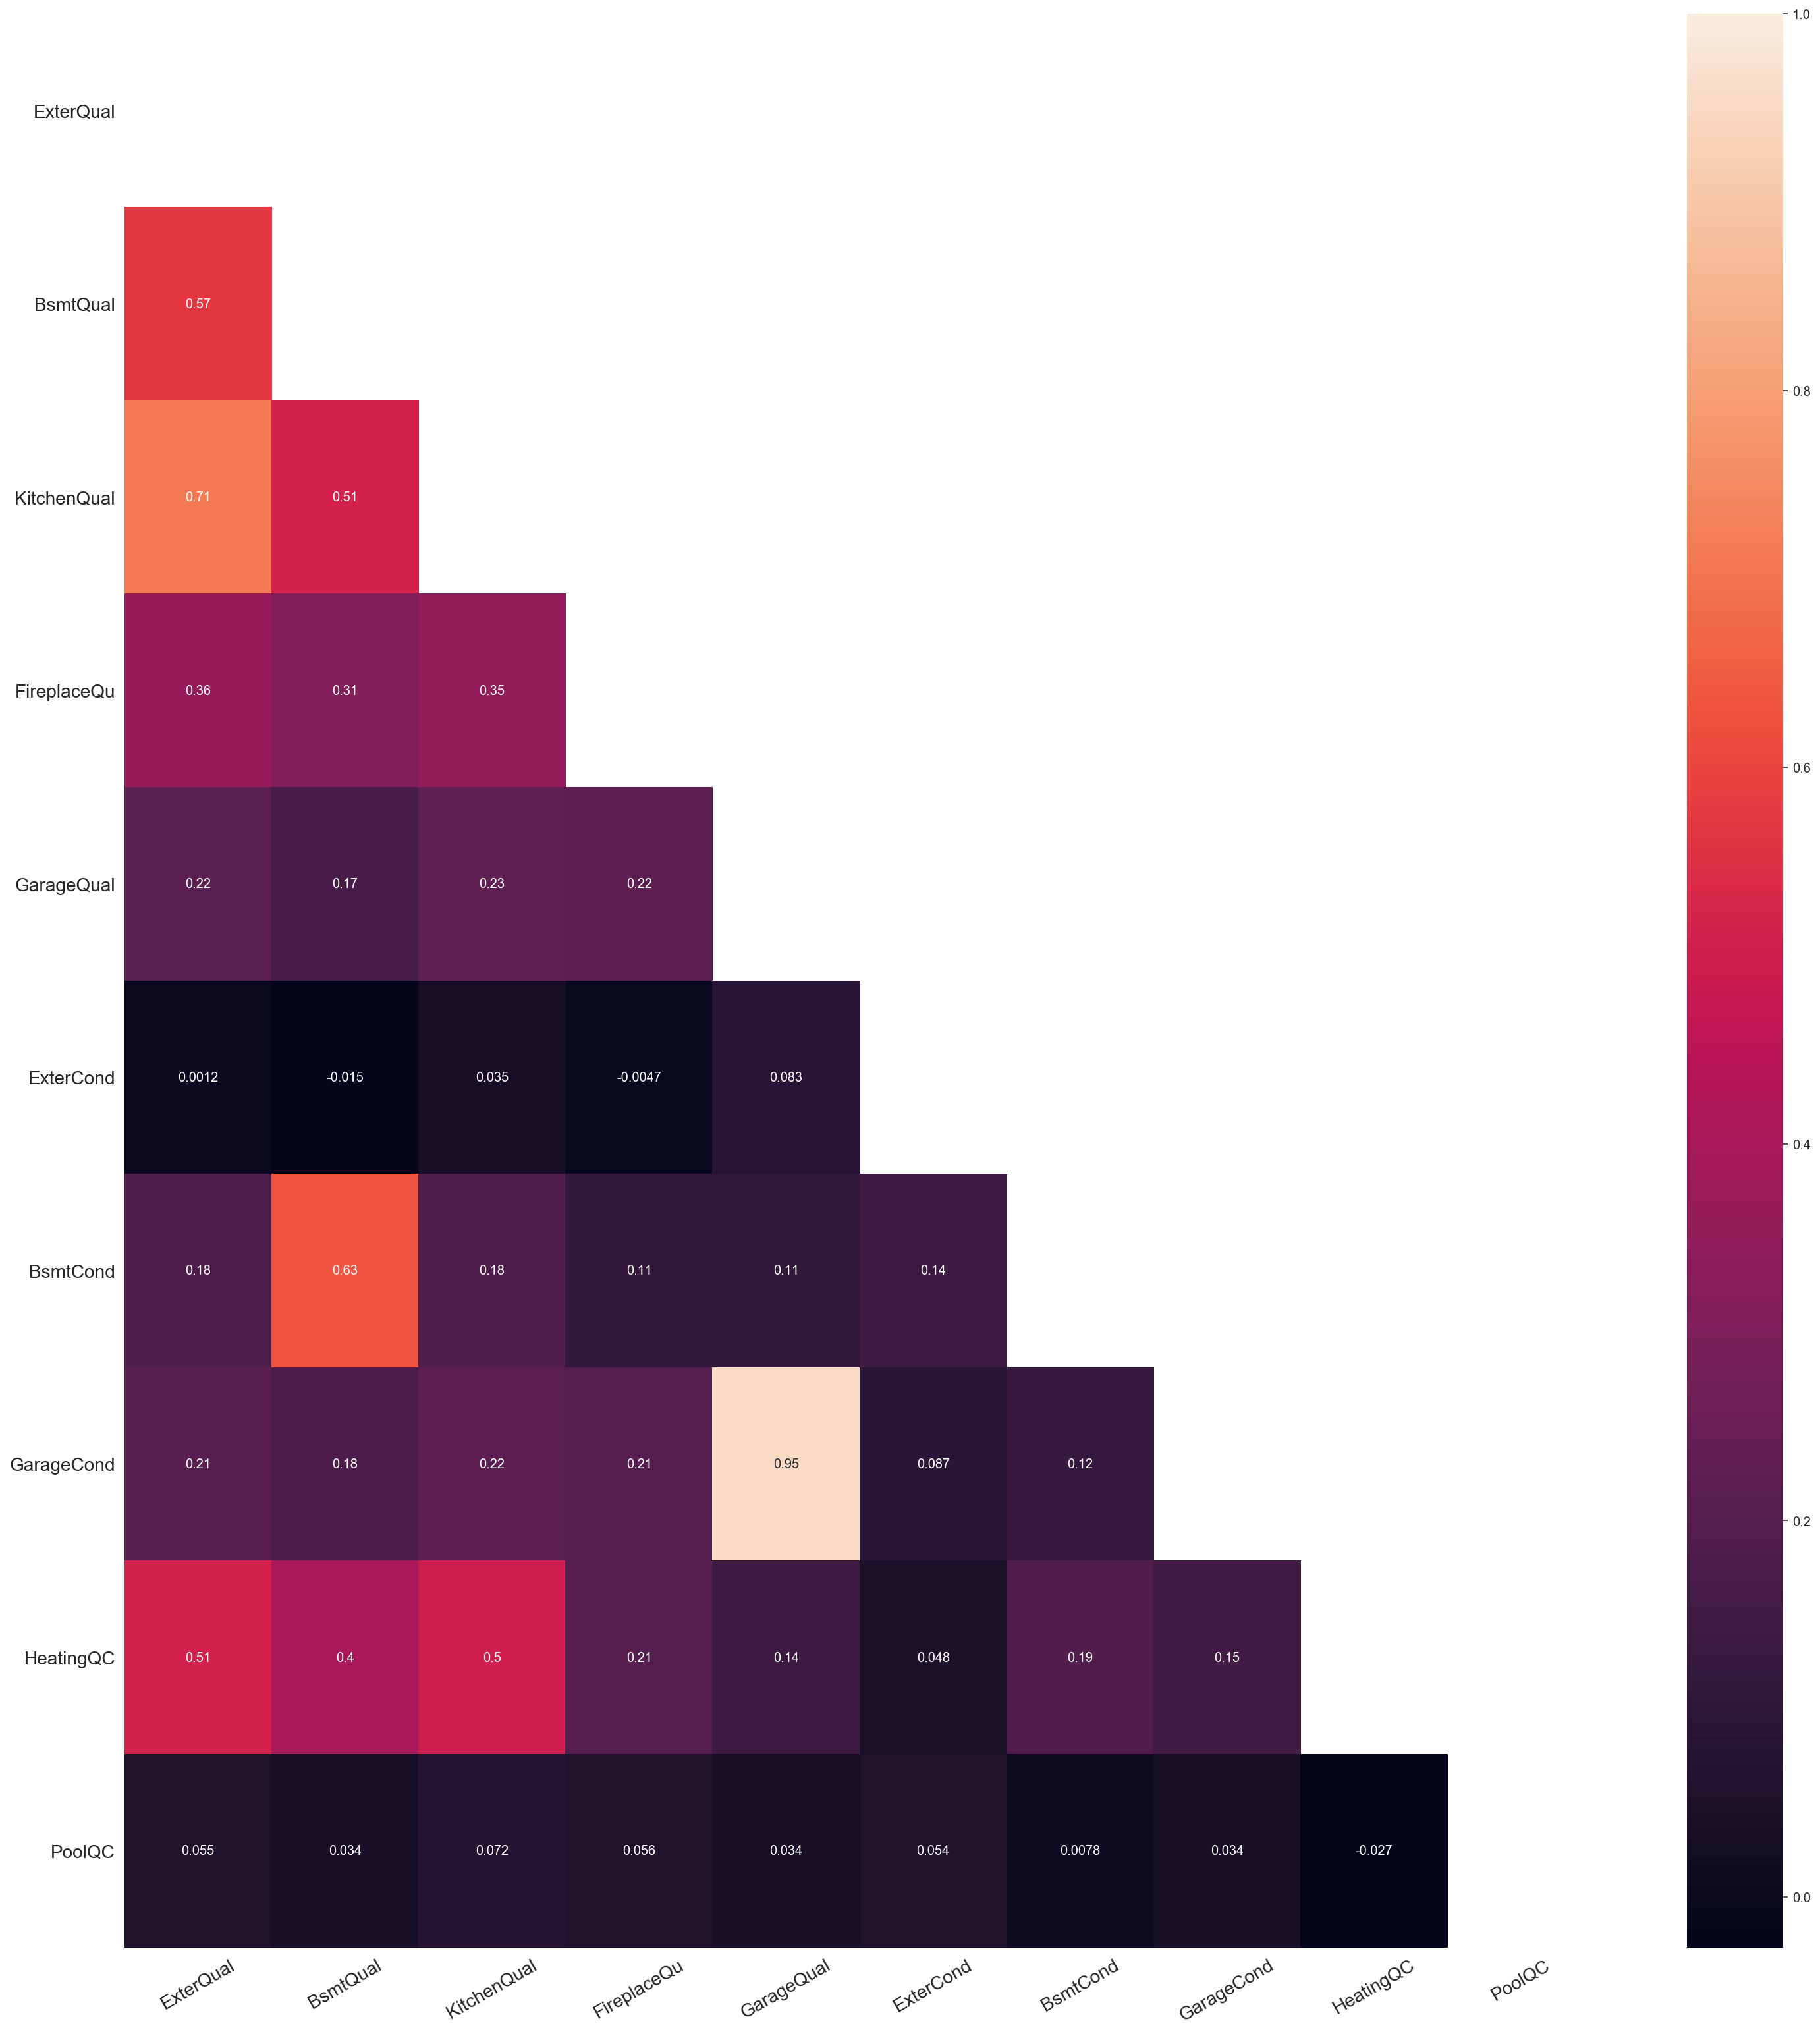

In [30]:
# Split df_pre_renovate dataFrame into 2 sub-dataFrame
df_pre_dumm = get_categorical(df_pre_renovate)
df_pre_dumm = pd.get_dummies(df_pre_dumm)
df_temp = get_numberics(df_pre_renovate)
correlation_heat_map(df_temp)

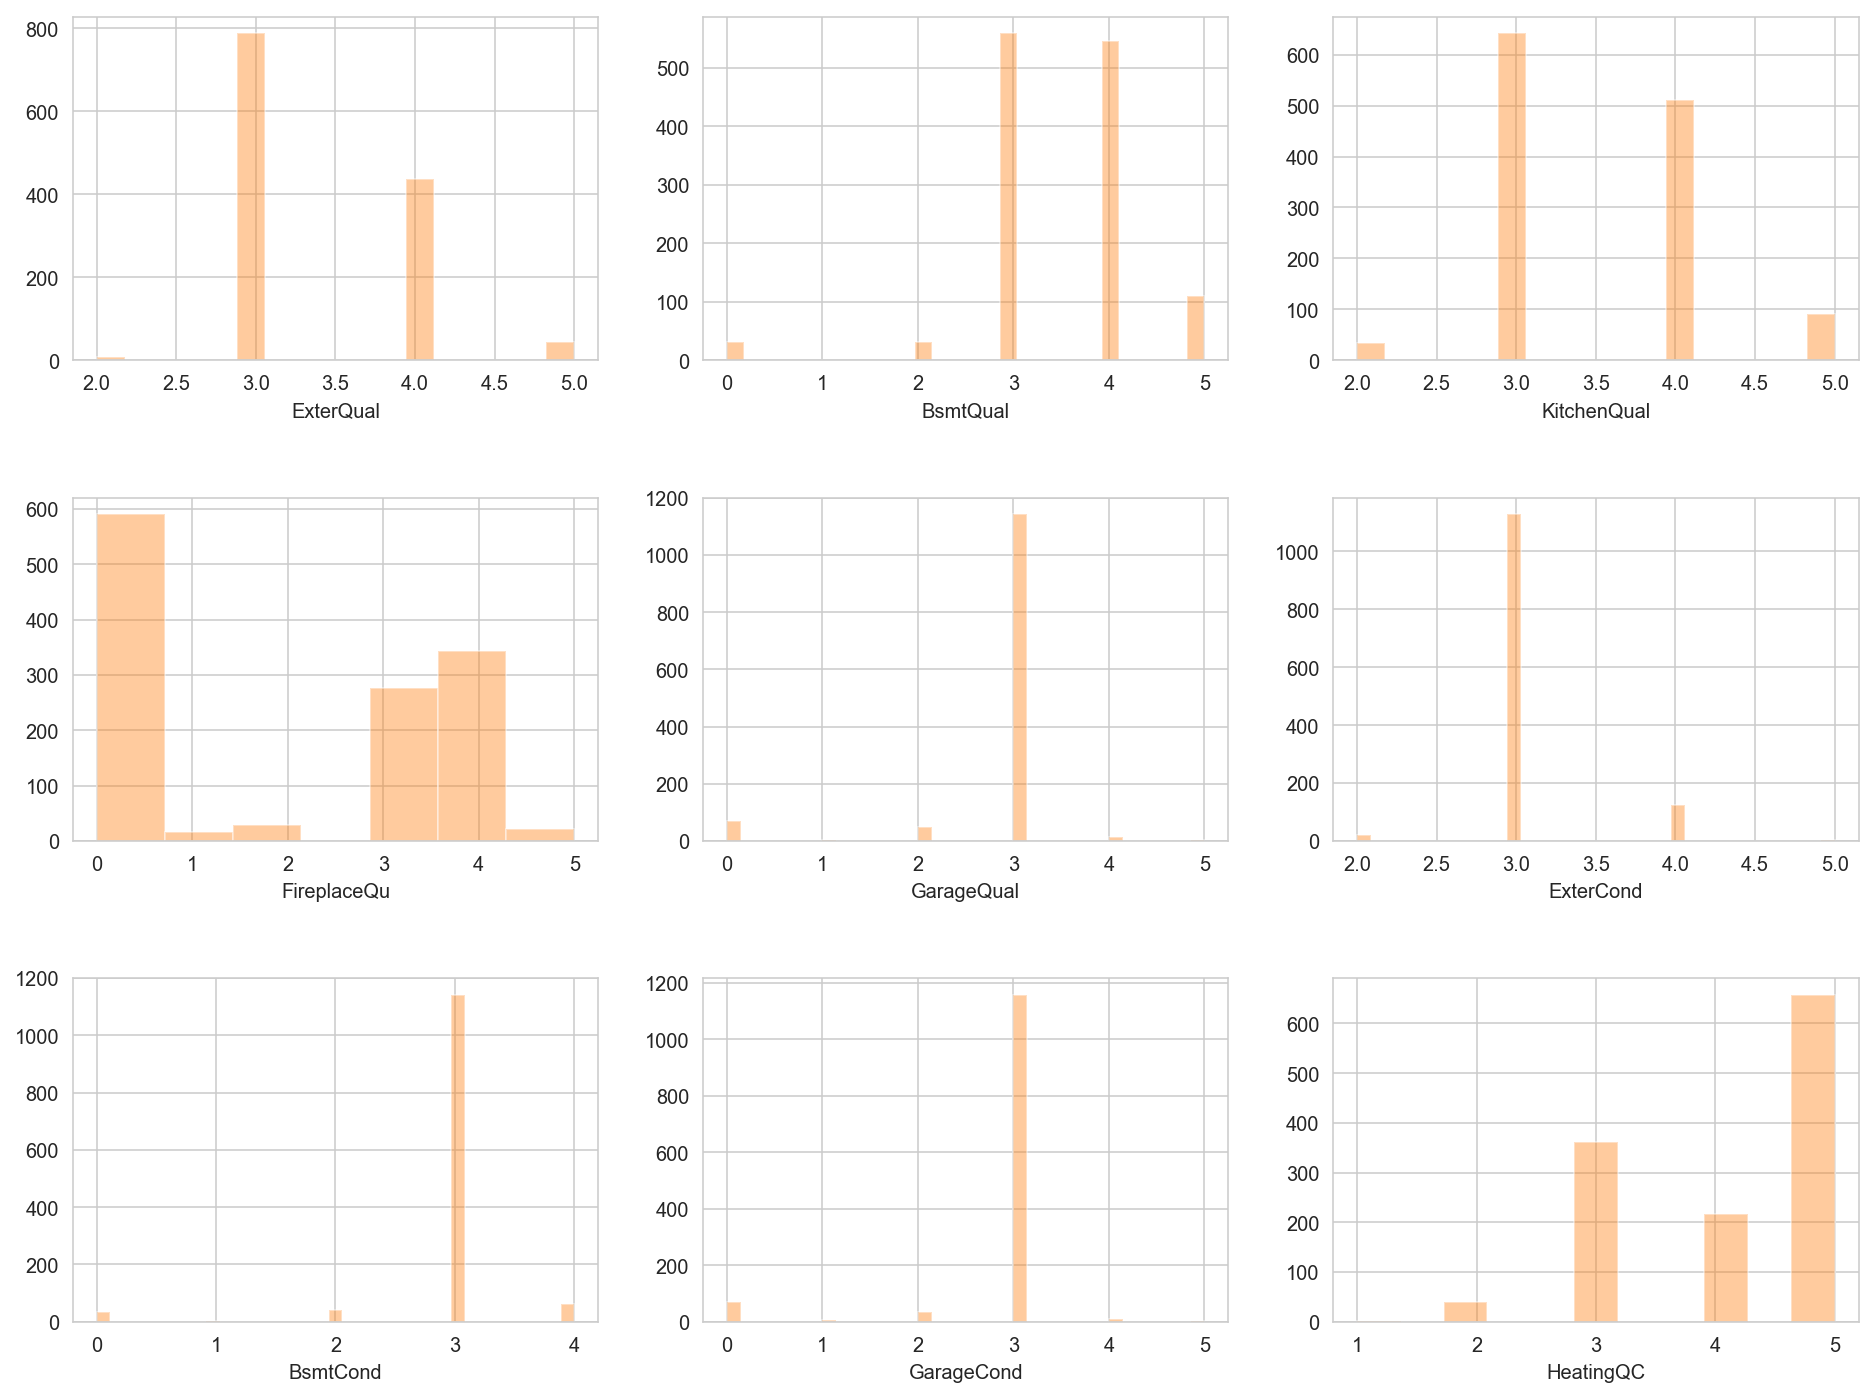

In [31]:
plotting_features(df_temp)

In [32]:
# Combine dummies and renovate-able columns
df_pre_renovate = pd.concat([df_temp, df_pre_dumm], axis=1, join='inner')

# Apply samething to df_post_renovate
df_post_dumm = get_categorical(df_post_renovate)
df_post_dumm = pd.get_dummies(df_post_dumm)
df_temp = get_numberics(df_post_renovate)
df_post_renovate = pd.concat([df_temp, df_post_dumm], axis=1, join='inner')

In [33]:
df_pre_renovate.shape

(1278, 54)

In [34]:
df_post_renovate.shape

(172, 41)

In [35]:
# Find "Unique" column names which are contained in both dataframe
df_temp = set(df_pre_renovate.columns).intersection(set(df_post_renovate.columns))

# turn into list
df_temp = list(df_temp)

# Standard 2 dataframe
df_pre_renovate = df_pre_renovate[df_temp].copy()
df_post_renovate = df_post_renovate[df_temp].copy()

In [36]:
# Standarize selected features
ss = StandardScaler()

# Init [TRAINING] X & y
y = df_pre_num['SalePrice'].values
df_pre_num.drop(labels=['SalePrice'],axis=1, inplace=True)
X = df_pre_num.copy()
X = ss.fit_transform(X)

# Init [TEST] X & y
y_test = df_post_2010['SalePrice'].values
# df_post_num.drop(labels=['SalePrice'],axis=1, inplace=True)
X_test = df_post_num.copy()
X_test = ss.fit_transform(X_test)

print(X.shape, X_test.shape)

# Get optimal alpha
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)

# Predict y [TRAINING & TEST]
fixed_ridge = Ridge(alpha = optimal_ridge.alpha_).fit(X,y)
pred_fixed_train = fixed_ridge.predict(X)
print("Fixed Train: ", len(pred_fixed_train))
pred_fixed_test = fixed_ridge.predict(X_test)
print("Fixed Test: ", len(pred_fixed_test))

# Calculate Residuals
residual_train = abs(y - pred_fixed_train)
residual_test = abs(y_test - pred_fixed_test)
print(residual_train)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(1278, 21) (172, 21)
Fixed Train:  1278
Fixed Test:  172
[ 9457.58187124 13080.02755452  2121.84323997 ...  7755.7290449
 15873.52971525  8985.98341793]


C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
len(residual_train)

1278

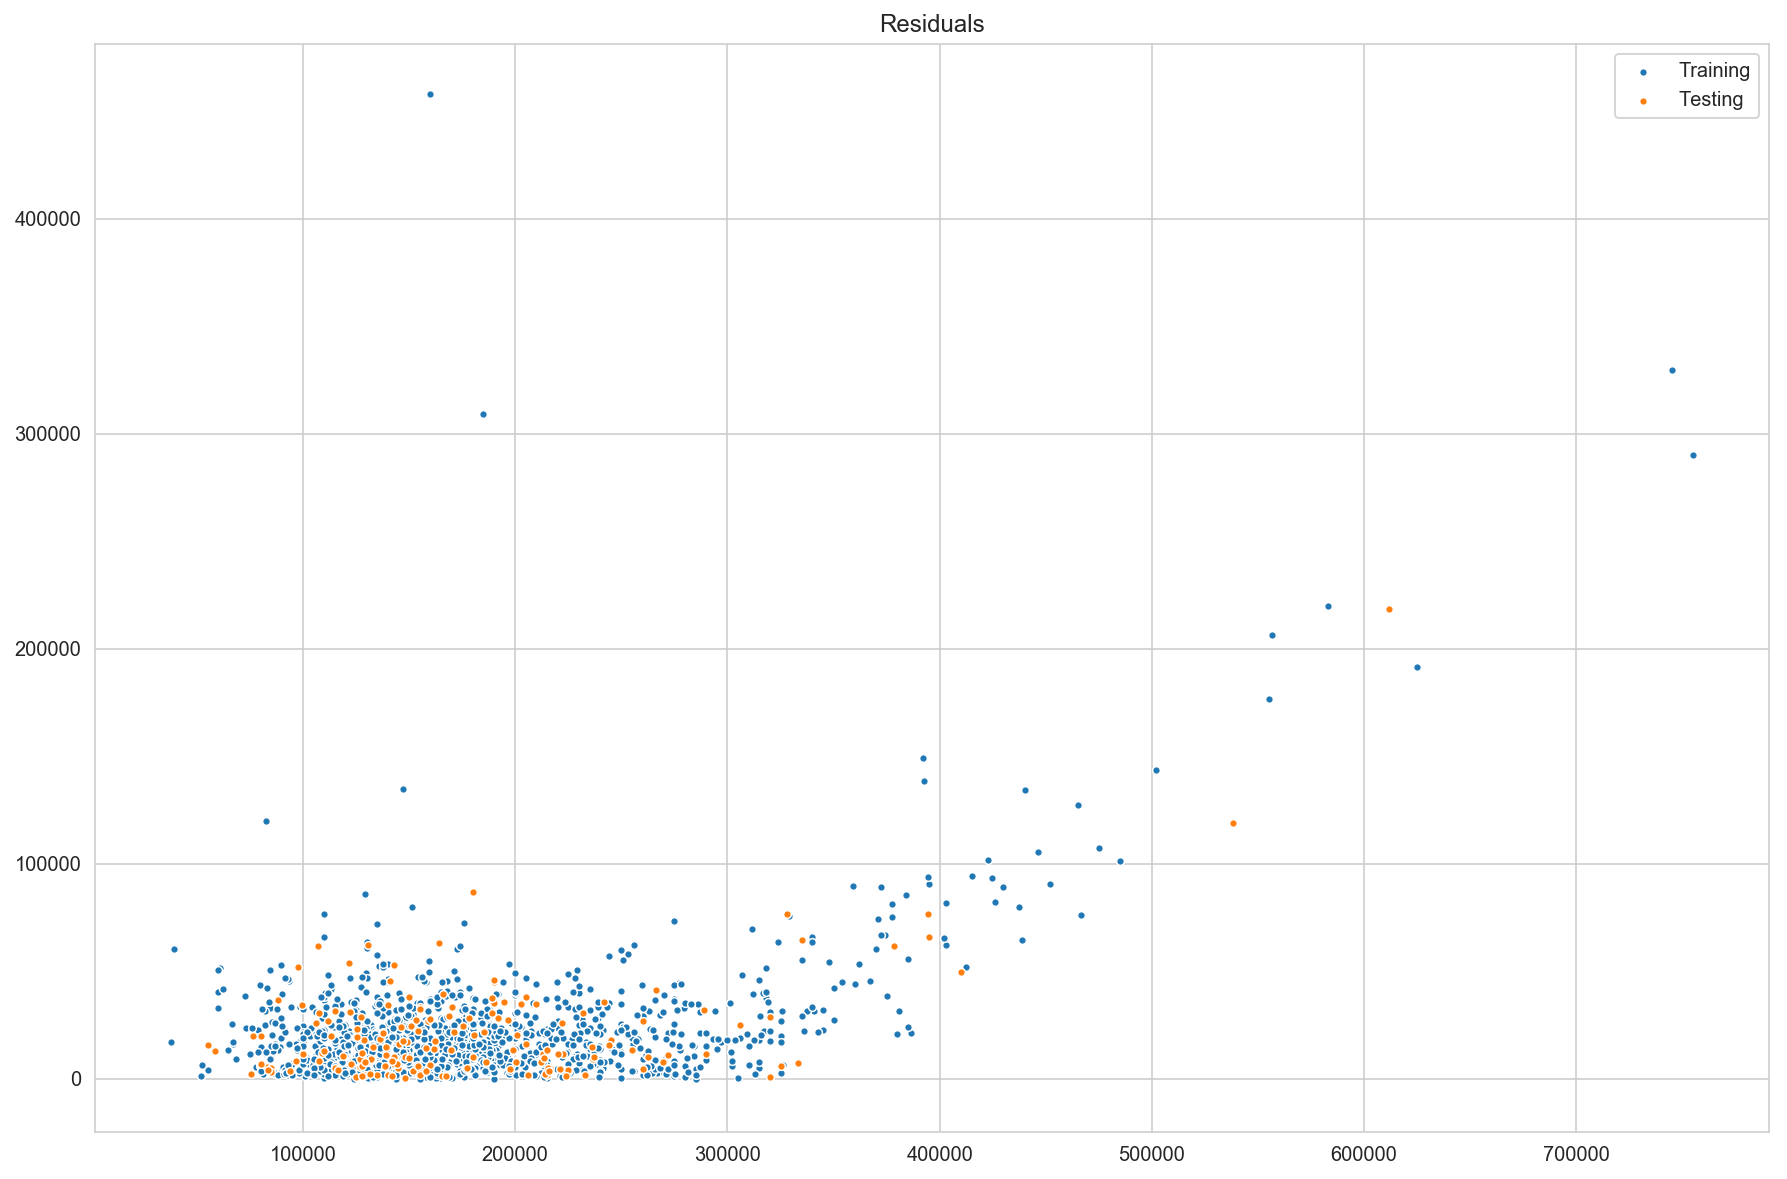

In [38]:
# Plotting
fig, axis = plt.subplots(1, 1 , figsize=(15,10))
# plt.scatter(x=y, y=residual_train,alpha=0.5)
# plt.scatter(x=y_test, y=residual_test,alpha=0.5)
sns.scatterplot(x=y, y=residual_train, ax=axis, label='Training', s=15)
sns.scatterplot(x=y_test, y=residual_test, ax=axis, label='Testing', s=15)
plt.title('Residuals')
plt.legend()
plt.show()

In [39]:
ss_renovate = StandardScaler()

# Init X_train, y_train, X_test, y_test
# y_train = df_pre_renovate['']
X = df_pre_renovate.copy()
# residual_train

X_test = df_post_renovate.copy()

# Fit features by StandardScaler
ss_renovate.fit(X)
X = ss_renovate.transform(X)
X_test = ss_renovate.transform(X_test)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
./pythons/mine.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  ]
./pythons/mine.py:13: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  __list_yes_no__ = ['N', 'Y']


In [40]:
type(residual_train)

numpy.ndarray

In [41]:
type(X)

numpy.ndarray

In [42]:
## Perform renovated features
model2 = LinearRegression().fit(X, residual_train)
prediction2 = model2.predict(X_test)
print("Mean: ", np.mean(prediction2))

Mean:  20151.86638408621


In [54]:
scores2 = model2.score(X_test, residual_test)
print(scores2)

0.16232532264218558


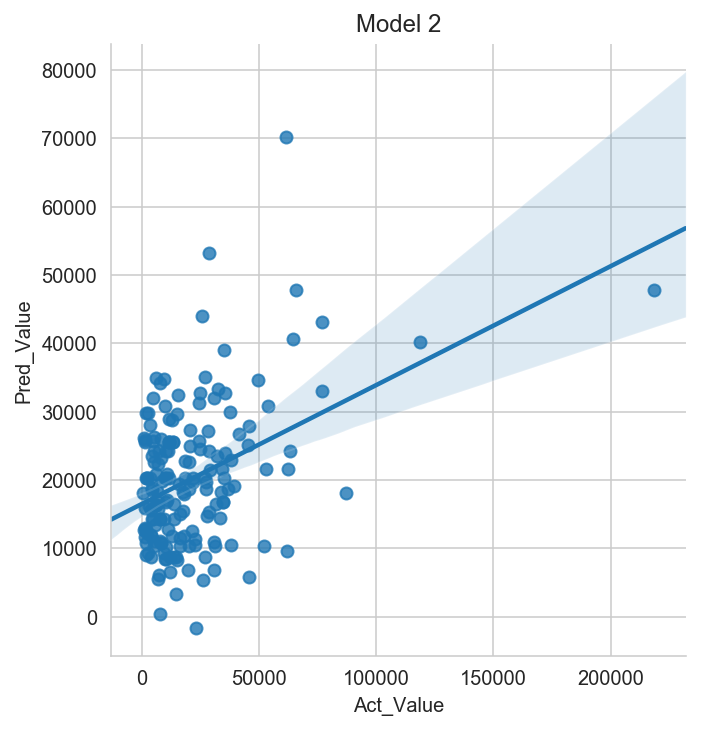

In [46]:
helper = pd.DataFrame()
helper['Act_Value'] = residual_test
helper['Pred_Value'] = prediction2
sns.lmplot(x='Act_Value', y='Pred_Value', data = helper);
ax = plt.gca()
ax.set_title("Model 2");

Train-split-test (Test) score:  0.38069568442679225
Train-split-test (Train) score:  0.23641696837795134
-----------------------------------------------------


K-Fold Cross-validated scores: 

Score Mean:  -1.502992584038181e+21
Cross-Predicted R2:  -2.3107759856143877e+21
-----------------------------------------------------




{'TTS-Train': 0.23641696837795134,
 'TTS-Test': 0.38069568442679225,
 'KF-CV score': array([-2.92329085e-01, -3.73400088e-01,  3.21659089e-02,  1.64566786e-01,
        -1.50299258e+22,  5.69793202e-02, -5.73743310e-01, -9.25427608e-02,
         1.79275356e-01, -1.20818443e-01]),
 'KF-CV Mean score': -1.502992584038181e+21,
 'R2 score': -2.3107759856143877e+21}

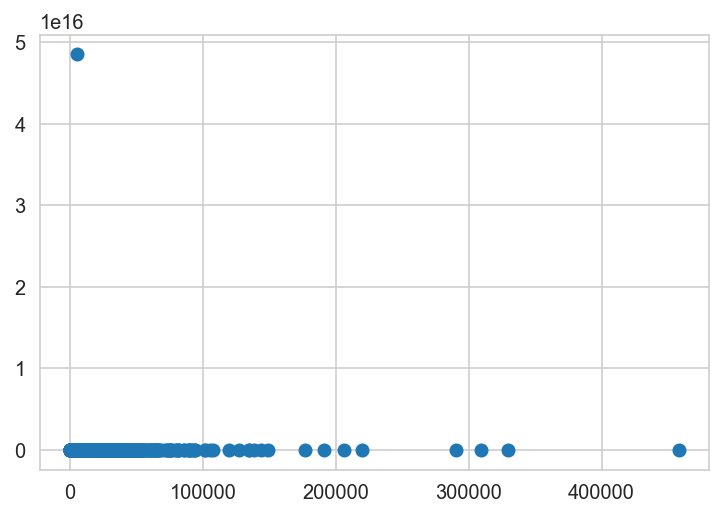

In [47]:
cross_validation(model2,X, residual_train)

In [48]:
#---------------------------------------------
# RidgeCV
#----------------------------------------------
# optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=30)
optimal_ridge.fit(X, residual_train)

print("Ridge Alpha: ", optimal_ridge.alpha_)

# Cross-validate the Ridge regression
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, residual_train, cv=10)

print(ridge_scores)
print("RidgeCV Mean: ", np.mean(ridge_scores))

Ridge Alpha:  2465.811075822604
[ 0.07306897  0.13929902  0.12057045  0.13065389  0.07246226  0.07888493
 -0.27945896  0.06025945  0.08867929  0.15060742]
RidgeCV Mean:  0.06350267257678241


C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
model2_r2 = r2_score(residual_test,prediction2)


In [50]:
model2_r2

0.16465857901662828

##### trust this model?


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: